In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torch
from torch.distributions.normal import Normal

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
device='cpu'
import numpy as np
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


import matplotlib.pyplot as plt

cuda:0


In [4]:
import numpy as np

# Define the joint state space for two units (4 states each)
joint_states = [(i, j) for i in range(4) for j in range(4)]
num_joint_states = len(joint_states)
# Sort the joint states based on the sum of values in each tuple
joint_states = sorted(joint_states, key=lambda x: sum(x))
# Example: Define a 4x4 joint transition matrix P((s1, s2) -> (s1', s2'))
P_joint = np.array([
    # Each row corresponds to a joint state, each column to the next joint state
    [0.4, 0.2, 0.1, 0.1, 0.05, 0.05, 0.02, 0.02, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0],  # (0,0) -> various states
    [0.3, 0.3, 0.1, 0.1, 0.07, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0],  # (0,1)
    [0.2, 0.2, 0.3, 0.1, 0.05, 0.1, 0.02, 0.02, 0.02, 0.02, 0.03, 0.02, 0.01, 0.01, 0.0, 0.0],  # (0,2)
    [0.1, 0.1, 0.2, 0.4, 0.05, 0.05, 0.05, 0.05, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.0, 0.0],  # (0,3)
    [0.3, 0.2, 0.1, 0.1, 0.2, 0.05, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0],  # (1,0)
    [0.2, 0.2, 0.1, 0.1, 0.3, 0.05, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0],  # (1,1)
    [0.2, 0.2, 0.1, 0.1, 0.05, 0.4, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.02, 0.01, 0.0, 0.0],  # (1,2)
    [0.1, 0.1, 0.2, 0.3, 0.05, 0.05, 0.2, 0.1, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0],  # (1,3)
    [0.3, 0.1, 0.1, 0.1, 0.05, 0.05, 0.02, 0.02, 0.3, 0.05, 0.05, 0.02, 0.02, 0.02, 0.02, 0.01],  # (2,0)
    [0.2, 0.2, 0.1, 0.1, 0.05, 0.05, 0.02, 0.02, 0.1, 0.4, 0.05, 0.02, 0.02, 0.01, 0.01, 0.01],  # (2,1)
    [0.1, 0.1, 0.2, 0.2, 0.05, 0.1, 0.02, 0.02, 0.05, 0.05, 0.3, 0.05, 0.02, 0.02, 0.01, 0.01],  # (2,2)
    [0.1, 0.1, 0.2, 0.3, 0.05, 0.05, 0.02, 0.02, 0.02, 0.02, 0.1, 0.3, 0.05, 0.05, 0.02, 0.02],  # (2,3)
    [0.2, 0.2, 0.1, 0.1, 0.05, 0.05, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.3, 0.1, 0.05, 0.05],  # (3,0)
    [0.1, 0.1, 0.2, 0.2, 0.05, 0.1, 0.02, 0.02, 0.02, 0.02, 0.05, 0.05, 0.1, 0.3, 0.05, 0.1],  # (3,1)
    [0.05, 0.05, 0.1, 0.1, 0.05, 0.05, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.05, 0.1, 0.4, 0.2],  # (3,2)
    [0.05, 0.05, 0.1, 0.1, 0.05, 0.05, 0.02, 0.02, 0.02, 0.02, 0.05, 0.05, 0.1, 0.1, 0.2, 0.3],  # (3,3)
])

# Set lower triangular elements to 0
for i in range(16):
    for j in range(i):
        P_joint[i, j] = 0
# Set lower triangular elements to 0
for i in range(16):
    for j in range(i+5,16):
        P_joint[i, j] = 0

P_joint=P_joint+np.eye(16,16)*0.8
# Normalize each row so the sum of probabilities equals 1
P_joint = P_joint / P_joint.sum(axis=1, keepdims=True)

# Check if the rows sum to 1
row_sums = P_joint.sum(axis=1)
print(row_sums)  # Should all be close to 1







P_joint



T_matrix=torch.tensor([[0.99, 0.01, 0.0,0.0],
        [0.00, 0.99, 0.01,0],
        [0.0, 0.00, 0.99,.01],
                      [0.0,0.0,0.0,1]], device=device) 

T_matrix1=torch.zeros(4,4,4)
T_matrix1[0,:,:]=T_matrix+torch.eye(4,4)*-0.0
T_matrix1[1,:,:]=T_matrix+torch.eye(4,4)*-0.3
T_matrix1[2,:,:]=T_matrix+torch.eye(4,4)*-0.5
T_matrix1[3,:,:]=T_matrix+torch.eye(4,4)*-0.7

T_matrix1=T_matrix1/torch.sum(T_matrix1, 2).reshape(4,4,1)

T_matrix1


s_0=torch.rand(3).to(device)

s_0=torch.tensor([1,0,0])
s_0=s_0/torch.sum(s_0)

O_matrix_mean=torch.tensor([1.5,3.5,5.5,7.5]).to(device)
O_matrix_std=torch.tensor([1.0,1.0,1.0,1.0]).to(device)


print(T_matrix)

print(s_0)



from torch.distributions.multivariate_normal import MultivariateNormal

def simulate_HMM(T_matrix_1,O_matrix,x,t):
    x=(0,0)
    current_state_idx = joint_states.index(x)
    states=[]
    t=0
    o=[]
    o1=[]
#     o_1=torch.matmul(x.to(device),O_matrix.to(device))
# #         print(o_1)
    o.append(Normal(O_matrix_mean[x[0]],1).sample().to(device))
    o1.append(Normal(O_matrix_mean[x[1]],1).sample().to(device))
    t=1
    h=torch.tensor([1,0,0,0.0])
    states.append(x)
    for i in range(1,5000):
#         print(i)
        # print(states)
        t+=1
        p = P_joint[current_state_idx]
        # print(current_state_idx)
        # Choose the next joint state based on the current transition probabilities
        next_state_idx = np.random.choice(range(num_joint_states), p=p)
        next_state = joint_states[next_state_idx]
        x=next_state
        # x[0]=x1.item()
        # x[1]=x2.item()
        states.append(x)
        # print(x[0])
        # print(alpha)
        o_1,o_2 = MultivariateNormal(torch.stack([O_matrix_mean[x[0]], O_matrix_mean[x[1]]]), 
                                     torch.tensor([[1, 0.0],
                              [0.0, 1]])).sample().t().to(device)
        o.append(o_1)
        o1.append(o_2)
        current_state_idx=next_state_idx

        
        t1=t
        
        if x[0]==3 and x[1]==3:
            break
    
    
    
    o=torch.tensor(o).to(device)
    o1=torch.tensor(o1).to(device)
    return o,o1,t

o=simulate_HMM(T_matrix,O_matrix_mean,torch.tensor([1.0,0,0.0]),1000)
o

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
tensor([[0.9900, 0.0100, 0.0000, 0.0000],
        [0.0000, 0.9900, 0.0100, 0.0000],
        [0.0000, 0.0000, 0.9900, 0.0100],
        [0.0000, 0.0000, 0.0000, 1.0000]])
tensor([1., 0., 0.])


(tensor([1.4756, 0.6804, 2.7678, 2.0367, 1.2115, 5.6837, 2.4076, 3.1805, 3.6250,
         2.4749, 4.8266, 3.5001, 4.1192, 4.7233, 4.6596, 3.6646, 5.3520, 2.4861,
         4.6500, 2.9121, 3.2081, 2.5721, 5.9001, 4.8265, 5.5643, 6.6938, 4.4957,
         3.9101, 5.0831, 5.0137, 4.3819, 4.5182, 3.8860, 4.1979, 2.4972, 2.4086,
         4.2013, 6.2038, 6.3692, 4.1848, 4.4928, 4.2619, 7.3141, 7.8300, 8.1961,
         6.6505, 6.0761, 6.0407, 8.0512, 7.6298, 6.4939, 7.0404, 9.2992]),
 tensor([1.2270, 2.4556, 7.2330, 6.2133, 5.0222, 3.8443, 3.6849, 3.5633, 4.7637,
         4.5349, 3.4548, 3.4774, 4.8514, 4.9840, 3.0157, 4.7972, 3.2486, 3.0399,
         2.5727, 2.6317, 4.6973, 4.6773, 4.7125, 2.5701, 4.9295, 3.0805, 2.8504,
         2.6555, 1.9770, 3.8998, 7.4212, 6.3133, 8.4235, 8.5171, 7.0436, 7.3298,
         6.9057, 5.1770, 3.4531, 5.9545, 7.1912, 7.4837, 4.0613, 4.7913, 5.1002,
         4.9094, 5.6902, 4.4467, 5.8119, 5.8341, 4.7222, 5.6623, 6.9879]),
 53)

In [5]:
plt.plot(o[0].cpu())
# plt.plot(o[1])

In [6]:
plt.plot(o[0].cpu())
plt.plot(o[1].cpu())

In [7]:
# pred1=[]
# for i in range(0, 100):
#             pred1.append(simulate_HMM(T_matrix, O_matrix_mean, s_0, 1))

# torch.save(pred1, 'DATA_NON_LINEAR.pth')

# print("pred1 list saved successfully.")

In [8]:
# f=distribution_initalize(o[0])

def Expectation_diff(o_1):
    return torch.sum(o_1[0])

def var_diff(o_1):
    return torch.sum(o_1[1])

def abs_diff(e):
    k=0
    for i,e1 in enumerate(e):
        for j,e2 in enumerate(e):
            if j==i+1:
                k+=torch.abs(e2-e1)
    return k



# MAIN MODEL 

In [9]:

class ATTENTION(nn.Module):
    def __init__(self, num_states=4):
        super(ATTENTION, self).__init__()
        num_heads=1
        hidden_dim=num_states
        self.num_states=num_states
        
        self.input_dim = num_states
        input_dim=num_states

        self.input_projection_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.input_projection1_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.input_projection2_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.attention_1 = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.fc_1 = nn.Linear(hidden_dim ,hidden_dim)
        

    def forward(self,  Q, K, V, t1):

        seq_len = Q.size(1)
        attn_mask = torch.triu(torch.ones(seq_len, seq_len, device=Q.device), diagonal=1)
        # print(attn_mask)
        attn_mask = attn_mask.masked_fill(attn_mask == 1, float('-inf')).masked_fill(attn_mask == 0, float(0.0))

        
        projected_inputs = self.input_projection_1(Q)  # [batch, seq_len, hidden_dim]
        projected_inputs1 = self.input_projection1_1(K)  # [batch, seq_len, hidden_dim]
        projected_inputs2 = self.input_projection2_1(V)  # [batch, seq_len, hidden_dim]
        attn_output, _ = self.attention_1(projected_inputs, projected_inputs1, projected_inputs2, attn_mask=attn_mask)  # [batch, seq_len, hidden_dim]
        pred = (F.tanh(self.fc_1(attn_output))+(t1))   # [batch, seq_len, output_dim]

        return pred


class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=300):
        super().__init__()
        self.base =3*(torch.tensor([0.0,0.25,0.5,1]))
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = 3*torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1)/max_len #/ torch.pow(10000, torch.arange(
            #0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        for i in range(4):
            self.P[:, :, i:i+1] = torch.cos(self.base[i]-X)
        
        # self.P[:, :, 0::2] = torch.cos(X)
        # self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)



class ATTENTION1(nn.Module):
    def __init__(self, num_states=4):
        super(ATTENTION1, self).__init__()
        num_heads=1
        hidden_dim=num_states
        self.num_states=num_states
        
        self.input_dim = num_states
        input_dim=num_states

        self.input_projection_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.input_projection1_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.input_projection2_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.attention_1 = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.fc_1 = nn.Linear(hidden_dim ,hidden_dim)
        

    def forward(self,  Q, K,V):

        seq_len = Q.size(1)
        attn_mask = torch.triu(torch.ones(seq_len, seq_len, device=Q.device), diagonal=1)
        # print(attn_mask)
        attn_mask = attn_mask.masked_fill(attn_mask == 1, float('-inf')).masked_fill(attn_mask == 0, float(0.0))

        
        projected_inputs = self.input_projection_1(Q)  # [batch, seq_len, hidden_dim]
        projected_inputs1 = self.input_projection1_1(K)  # [batch, seq_len, hidden_dim]
        projected_inputs2 = self.input_projection2_1(V)  # [batch, seq_len, hidden_dim]
        attn_output, _ = self.attention_1(projected_inputs, projected_inputs1, projected_inputs2, attn_mask=attn_mask)  # [batch, seq_len, hidden_dim]
        pred = (F.leaky_relu(self.fc_1(attn_output))+ V )   # [batch, seq_len, output_dim]

        return pred



In [10]:

class ATTENTION(nn.Module):
    def __init__(self, num_states=4):
        super(ATTENTION, self).__init__()
        num_heads=1
        hidden_dim=num_states
        self.num_states=num_states
        
        self.input_dim = num_states
        input_dim=num_states

        self.input_projection_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.input_projection1_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.input_projection2_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.attention_1 = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.fc_1 = nn.Linear(hidden_dim ,hidden_dim)
        

    def forward(self,  Q, K, V, t1):

        seq_len = Q.size(1)
        attn_mask = torch.triu(torch.ones(seq_len, seq_len, device=Q.device), diagonal=1)
        # print(attn_mask)
        attn_mask = attn_mask.masked_fill(attn_mask == 1, float('-inf')).masked_fill(attn_mask == 0, float(0.0))

        
        projected_inputs = self.input_projection_1(Q)  # [batch, seq_len, hidden_dim]
        projected_inputs1 = self.input_projection1_1(K)  # [batch, seq_len, hidden_dim]
        projected_inputs2 = self.input_projection2_1(V)  # [batch, seq_len, hidden_dim]
        attn_output, _ = self.attention_1(projected_inputs, projected_inputs1, projected_inputs2, attn_mask=attn_mask)  # [batch, seq_len, hidden_dim]
        pred = (F.tanh(self.fc_1(attn_output))+(t1))   # [batch, seq_len, output_dim]

        return pred


class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=300):
        super().__init__()
        self.base =3*(torch.tensor([0.0,0.25,0.5,1]))
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = 3*torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1)/max_len #/ torch.pow(10000, torch.arange(
            #0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        for i in range(4):
            self.P[:, :, i:i+1] = torch.cos(self.base[i]-X)
        
        # self.P[:, :, 0::2] = torch.cos(X)
        # self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)



class ATTENTION1(nn.Module):
    def __init__(self, num_states=4):
        super(ATTENTION1, self).__init__()
        num_heads=1
        hidden_dim=4
        self.num_states=4
        
        self.input_dim = num_states
        input_dim=num_states

        self.input_projection_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.input_projection1_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.input_projection2_1 = nn.Linear(hidden_dim, hidden_dim,bias=False)
        self.attention_1 = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.fc_1 = nn.Linear(hidden_dim ,hidden_dim)
        

    def forward(self,  Q, K,V):

        seq_len = Q.size(1)
        attn_mask = torch.triu(torch.ones(seq_len, seq_len, device=Q.device), diagonal=1)
        # print(attn_mask)
        attn_mask = attn_mask.masked_fill(attn_mask == 1, float('-inf')).masked_fill(attn_mask == 0, float(0.0))

        
        projected_inputs = self.input_projection_1(Q)  # [batch, seq_len, hidden_dim]
        projected_inputs1 = self.input_projection1_1(K)  # [batch, seq_len, hidden_dim]
        projected_inputs2 = self.input_projection2_1(V)  # [batch, seq_len, hidden_dim]
        attn_output, _ = self.attention_1(projected_inputs, projected_inputs1, projected_inputs2, attn_mask=attn_mask)  # [batch, seq_len, hidden_dim]
        pred = (F.leaky_relu(self.fc_1(attn_output))+ V )   # [batch, seq_len, output_dim]

        return pred








class Net(nn.Module):
    def __init__(self, num_states=5):
        super(Net, self).__init__()
        num_heads=1
        hidden_dim=num_states
        num_hiddens=num_states
        self.num_states=num_states
        self.s_0 = nn.Parameter(torch.rand(num_states), requires_grad=True)
        self.s_01 = nn.Parameter(torch.rand(num_states), requires_grad=True)
        self.mu = nn.Parameter(torch.rand(num_states), requires_grad=True)
        self.mu1 = nn.Parameter(torch.rand(num_states), requires_grad=True)
        self.sigma =nn.Parameter(torch.zeros(num_states), requires_grad=True)
        self.sigma1 = nn.Parameter(torch.zeros(num_states), requires_grad=True)

        self.base =3*(torch.tensor([0.0,0.25,0.5,1]))
        # self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        max_len=300
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = 3*torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1)/max_len #/ torch.pow(10000, torch.arange(
            #0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        for i in range(4):
            self.P[:, :, i:i+1] = torch.cos(self.base[i]-X)

        
        self.input_dim = num_states
        input_dim=num_states
        
        self.fc = nn.Linear(input_dim+1 ,hidden_dim,bias=False)
        self.fc1 = nn.Linear(input_dim+1 ,hidden_dim,bias=False)
        self.fc2 = nn.Linear(1 ,hidden_dim)
        self.fc3 = nn.Linear(1 ,hidden_dim)
        self.fc4 = nn.Linear(hidden_dim ,hidden_dim)
        self.fc5 = nn.Linear(hidden_dim ,hidden_dim)
        
        self.A1=ATTENTION(num_states)
        self.A2=ATTENTION(num_states)
        self.A3=ATTENTION(num_states)
        self.A4=ATTENTION(num_states)
        self.A5=ATTENTION(num_states)
        self.A6=ATTENTION(num_states)
        self.A7=ATTENTION(num_states)
        self.A8=ATTENTION(num_states)
        self.A9=ATTENTION(num_states)
        self.A10=ATTENTION(num_states)

        # LSTM Encoder
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, bidirectional=False)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, bidirectional=False)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, bidirectional=False)
        self.lstm4 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, bidirectional=False)
        

        self.pos_encoding = PositionalEncoding(hidden_dim, 0)
    def forward(self,  t, pred,pred1, prob=0.3):

        s_0=F.softmax(self.s_0).unsqueeze(0).repeat(1,1).unsqueeze(1).repeat(4,1,1)
        s_01=F.softmax(self.s_01).unsqueeze(0).repeat(1,1).unsqueeze(1).repeat(4,1,1)

        # print(s_0.shape)
        exp_mu = torch.exp(self.mu)           # Step 1: Take exponential
        cumsum_mu = torch.cumsum(exp_mu, dim=0)


        exp_mu1 = torch.exp(self.mu1)           # Step 1: Take exponential
        cumsum_mu1 = torch.cumsum(exp_mu1, dim=0)

        
        pred_base=pred.clone()
        pred1_base=pred1.clone()

        pred=pred.unsqueeze(0).repeat(1,1).unsqueeze(2).repeat(4,1,4).clone()
        pred1=pred1.unsqueeze(0).repeat(1,1).unsqueeze(2).repeat(4,1,4).clone()

        new_pred = pred.clone()
        for i in range(self.num_states):
            dist = Normal(cumsum_mu[i], torch.exp(self.sigma[i]))
            o_1 = torch.exp(dist.log_prob(pred_base))
            
            new_pred[:,:,i] = o_1#*1/self.num_states
        pred=new_pred.clone()
        
        new_pred = pred1.clone()
        for i in range(self.num_states):
            dist = Normal(cumsum_mu1[i], torch.exp(self.sigma1[i]))
            o_1 = torch.exp(dist.log_prob(pred1_base))
             
            new_pred[:,:,i] = o_1#*1/self.num_states
        pred1=new_pred.clone()

        # Generate a binary mask to decide which timestamps to replace
        mask = (torch.rand(4, pred.shape[1], 1, device=pred.device) < prob).float()
        replacement = torch.full_like(pred, -1.0)
        pred = pred * (1 - mask) + replacement * mask
        pred1 = pred1 * (1 - mask) + replacement * mask
        
        # print(pred.shape)
        pred=pred/torch.sum(pred,dim=2, keepdim=True)
        pred1=pred1/torch.sum(pred1,dim=2, keepdim=True)
        # print(pred[0,0])

        position = torch.arange(0, t, device=device).unsqueeze(0).repeat(4,1).unsqueeze(2).float()
        # print(position.shape)
        t1=F.tanh(self.fc2(position)).float()
        t2=F.tanh(self.fc3(position)).float()
        # t2=self.fc3(position).float()
        # pred=torch.concat([pred, position], dim=2)
        # pred1=torch.concat([pred1, position], dim=2)
        # print(pred.shape)
        


        # pred = F.leaky_relu(self.fc(pred))
        # pred1 = F.leaky_relu(self.fc1(pred1))
        pred_base1=pred.clone()
        pred1_base1=pred1.clone()

        pred_1, _ = self.lstm1(pred)
        pred1_1, _ = self.lstm2(pred1)
        pred=F.tanh(pred)+pred_1
        pred1=F.tanh(pred1)+pred1_1

        
        # pred = F.leaky_relu(self.fc(pred)) + P
        # pred1 = F.leaky_relu(self.fc1(pred1)) + P
        # pred = pred + t1
        # pred1 = pred1 + t1
        


        
        pred=self.A1(pred,pred,pred,pred_base1)
        # pred=self.A2(pred,pred,pred,t1)
        # pred=self.A3(pred,pred,pred,t1)

        
        pred1=self.A4(pred1,pred1,pred1,pred1_base1)
        # pred1=self.A5(pred1,pred1,pred1,t1)
        # pred1=self.A6(pred1,pred1,pred1,t1)

        pred_1, _ = self.lstm3(pred)
        pred1_1, _ = self.lstm4(pred1)
        pred=F.tanh(pred)+pred_1
        pred1=F.tanh(pred1)+pred1_1


        

        pred_1=self.A7(pred,pred1,pred,pred)
        # pred_1=self.A8(pred_1,pred1,pred_1)

        
        pred1_1=self.A9(pred1,pred ,pred1,pred1)
        # pred1_1=self.A10(pred1_1,pred ,pred1_1)

        pred=pred_1.clone()
        pred1=pred1_1.clone()


        pred = F.softmax(self.fc4(pred)+pred, dim=2)
        pred1 = F.softmax(self.fc5(pred1)+pred1, dim=2)

        # print(pred.shape)

        

        

        
        pred_1=torch.zeros((pred.shape[0], pred.shape[1],self.num_states))
        pred1_1=torch.zeros((pred1.shape[0], pred1.shape[1],self.num_states))
        pred=torch.concat([s_0,pred], dim=1)
        pred1=torch.concat([s_01,pred1], dim=1)
        # print(pred.shape)
        
        
        
        # print(pred.shape)


        
        for i in range(self.num_states):
            dist = Normal(cumsum_mu[i], torch.exp(self.sigma[i]))
            o_1 = torch.exp(dist.log_prob(pred_base))
             
            pred_1[:,:,i] = o_1*pred[:,:-1,i] 


        for i in range(self.num_states):
            dist = Normal(cumsum_mu1[i], torch.exp(self.sigma1[i]))
            o_1 = torch.exp(dist.log_prob(pred1_base))
             
            pred1_1[:,:,i] = o_1*pred1[:,:-1,i] 


    
        KL=torch.sum(F.softmax(pred_1, dim=2)*torch.log(pred[0,:-1]/F.softmax(pred_1, dim=2)))
        KL+=torch.sum(F.softmax(pred1_1, dim=2)*torch.log(pred1[0,:-1]/F.softmax(pred1_1, dim=2)))
        
        pred_1=torch.sum(pred_1, dim=2)
        pred_1=torch.log(pred_1)
        pred_1=torch.sum(pred_1, dim=1)


        pred1_1=torch.sum(pred1_1, dim=2)
        pred1_1=torch.log(pred1_1)
        pred1_1=torch.sum(pred1_1, dim=1)


        


        return pred_1, pred1_1,KL



    

    def training1(self,  t, pred,pred1,m1,m2, prob=0.0):

        s_0=F.softmax(self.s_0).unsqueeze(0).repeat(1,1).unsqueeze(1).repeat(100,1,1)
        s_01=F.softmax(self.s_01).unsqueeze(0).repeat(1,1).unsqueeze(1).repeat(100,1,1)

        # print(s_0.shape)
        exp_mu = torch.exp(self.mu)           # Step 1: Take exponential
        cumsum_mu = torch.cumsum(exp_mu, dim=0)


        exp_mu1 = torch.exp(self.mu1)           # Step 1: Take exponential
        cumsum_mu1 = torch.cumsum(exp_mu1, dim=0)

        
        pred_base=pred.clone()
        pred1_base=pred1.clone()

        #pred=pred.unsqueeze(0).repeat(1,1).unsqueeze(2).repeat(4,1,4).clone()
        #pred1=pred1.unsqueeze(0).repeat(1,1).unsqueeze(2).repeat(4,1,4).clone()

        new_pred = pred.clone().unsqueeze(2).repeat(1,1,self.num_states).clone()
        for i in range(self.num_states):
            dist = Normal(cumsum_mu[i], torch.exp(self.sigma[i]))
            o_1 = torch.exp(dist.log_prob(pred_base))
            #print(o_1.shape)
            #print(new_pred[:,:,i].shape)
            new_pred[:,:,i] = o_1#*1/self.num_states
        pred=new_pred.clone()
        
        new_pred = pred1.clone().unsqueeze(2).repeat(1,1,self.num_states).clone()
        for i in range(self.num_states):
            dist = Normal(cumsum_mu1[i], torch.exp(self.sigma1[i]))
            o_1 = torch.exp(dist.log_prob(pred1_base))
             
            new_pred[:,:,i] = o_1#*1/self.num_states
        pred1=new_pred.clone()
        # print(pred.shape)
        pred=pred/torch.sum(pred,dim=2, keepdim=True)
        pred1=pred1/torch.sum(pred1,dim=2, keepdim=True)
        # print(pred[0,0])


        # pred = F.leaky_relu(self.fc(pred))
        # pred1 = F.leaky_relu(self.fc1(pred1))
        pred_base1=pred.clone()
        pred1_base1=pred1.clone()

        pred_1, _ = self.lstm1(pred)
        pred1_1, _ = self.lstm2(pred1)
        pred=F.tanh(pred)+pred_1
        pred1=F.tanh(pred1)+pred1_1
        pred=self.A1(pred,pred,pred,pred_base1)
        pred1=self.A4(pred1,pred1,pred1,pred1_base1)
        pred_1, _ = self.lstm3(pred)
        pred1_1, _ = self.lstm4(pred1)
        pred=F.tanh(pred)+pred_1
        pred1=F.tanh(pred1)+pred1_1
        pred_1=self.A7(pred,pred1,pred,pred)
        pred1_1=self.A9(pred1,pred ,pred1,pred1)
        pred=pred_1.clone()
        pred1=pred1_1.clone()
        pred = F.softmax(self.fc4(pred)+pred, dim=2)
        pred1 = F.softmax(self.fc5(pred1)+pred1, dim=2)
        

        

        
        pred_1=torch.zeros((pred.shape[0], pred.shape[1],self.num_states)).cuda()
        pred1_1=torch.zeros((pred1.shape[0], pred1.shape[1],self.num_states)).cuda()
        pred=torch.concat([s_0,pred], dim=1)
        pred1=torch.concat([s_01,pred1], dim=1)
        # print(pred.shape)
        
        
        
        # print(pred.shape)


        
        for i in range(self.num_states):
            dist = Normal(cumsum_mu[i], torch.exp(self.sigma[i]))
            o_1 = torch.exp(dist.log_prob(pred_base))
             
            pred_1[:,:,i] = o_1*pred[:,:-1,i] 


        for i in range(self.num_states):
            dist = Normal(cumsum_mu1[i], torch.exp(self.sigma1[i]))
            o_1 = torch.exp(dist.log_prob(pred1_base))
             
            pred1_1[:,:,i] = o_1*pred1[:,:-1,i] 


    
        KL=torch.sum(F.softmax(pred_1, dim=2)*torch.log(pred[0,:-1]/F.softmax(pred_1, dim=2)))
        KL+=torch.sum(F.softmax(pred1_1, dim=2)*torch.log(pred1[0,:-1]/F.softmax(pred1_1, dim=2)))
        
        pred_1=torch.sum(pred_1, dim=2)
        pred_1=torch.log(pred_1)
        pred_1=torch.sum(pred_1*m1, dim=1)


        pred1_1=torch.sum(pred1_1, dim=2)
        pred1_1=torch.log(pred1_1)
        pred1_1=torch.sum(pred1_1*m2, dim=1)


        


        return pred_1, pred1_1,KL




    
    def state_filter(self,  t, pred,pred1, prob=0.0):
        s_0=F.softmax(self.s_0).unsqueeze(0).repeat(1,1).unsqueeze(1).repeat(4,1,1)
        s_01=F.softmax(self.s_01).unsqueeze(0).repeat(1,1).unsqueeze(1).repeat(4,1,1)

        # print(s_0.shape)
        exp_mu = torch.exp(self.mu)           # Step 1: Take exponential
        cumsum_mu = torch.cumsum(exp_mu, dim=0)


        exp_mu1 = torch.exp(self.mu)           # Step 1: Take exponential
        cumsum_mu1 = torch.cumsum(exp_mu1, dim=0)

        
        pred_base=pred.clone()
        pred1_base=pred1.clone()

        pred=pred.unsqueeze(0).repeat(1,1).unsqueeze(2).repeat(4,1,4).clone()
        pred1=pred1.unsqueeze(0).repeat(1,1).unsqueeze(2).repeat(4,1,4).clone()

        new_pred = pred.clone()
        for i in range(self.num_states):
            dist = Normal(cumsum_mu[i], torch.exp(self.sigma[i]))
            o_1 = torch.exp(dist.log_prob(pred_base))
            
            new_pred[:,:,i] = o_1#*1/self.num_states
        pred=new_pred.clone()
        
        new_pred = pred1.clone()
        for i in range(self.num_states):
            dist = Normal(cumsum_mu1[i], torch.exp(self.sigma1[i]))
            o_1 = torch.exp(dist.log_prob(pred1_base))
             
            new_pred[:,:,i] = o_1#*1/self.num_states
        pred1=new_pred.clone()

       
        # print(pred.shape)
        pred=pred/torch.sum(pred,dim=2, keepdim=True)
        pred1=pred1/torch.sum(pred1,dim=2, keepdim=True)
        # print(pred[0,0])

        position = torch.arange(0, t).unsqueeze(0).repeat(4,1).unsqueeze(2).float()
        # print(position.shape)
        t1=F.tanh(self.fc2(position)).float()
        t2=F.tanh(self.fc3(position)).float()
        # t2=self.fc3(position).float()
        # pred=torch.concat([pred, position], dim=2)
        # pred1=torch.concat([pred1, position], dim=2)
        # print(pred.shape)
        


        pred_base1=pred.clone()
        pred1_base1=pred1.clone()

        pred_1, _ = self.lstm1(pred)
        pred1_1, _ = self.lstm2(pred1)
        pred=F.tanh(pred)+pred_1
        pred1=F.tanh(pred1)+pred1_1
        pred=self.A1(pred,pred,pred,pred_base1)
        pred1=self.A4(pred1,pred1,pred1,pred1_base1)
        pred_1, _ = self.lstm3(pred)
        pred1_1, _ = self.lstm4(pred1)
        pred=F.tanh(pred)+pred_1
        pred1=F.tanh(pred1)+pred1_1
        pred_1=self.A7(pred,pred1,pred,pred)
        pred1_1=self.A9(pred1,pred ,pred1,pred1)
        pred=pred_1.clone()
        pred1=pred1_1.clone()
        pred = F.softmax(self.fc4(pred)+pred, dim=2)
        pred1 = F.softmax(self.fc5(pred1)+pred1, dim=2)

        

        

        
        pred_1=torch.zeros((pred.shape[0], pred.shape[1],self.num_states))
        pred1_1=torch.zeros((pred1.shape[0], pred1.shape[1],self.num_states))
        pred=torch.concat([s_0,pred], dim=1)
        pred1=torch.concat([s_01,pred1], dim=1)


        

        
        
        
        
        
        
        for i in range(self.num_states):
            dist = Normal(cumsum_mu[i], torch.exp(self.sigma[i]))
            o_1 = torch.exp(dist.log_prob(pred_base))
             
            pred_1[:,:,i] = o_1*pred[:,:-1,i] 


        for i in range(self.num_states):
            dist = Normal(cumsum_mu1[i], torch.exp(self.sigma1[i]))
            o_1 = torch.exp(dist.log_prob(pred1_base))
             
            pred1_1[:,:,i] = o_1*pred1[:,:-1,i] 


        pred_1=torch.softmax(pred_1, dim=2)
        # pred_1=torch.log(pred_1)
        # pred_1=torch.sum(pred_1, dim=1)


        pred1_1=torch.softmax(pred1_1, dim=2)
        # pred1_1=torch.log(pred1_1)
        # pred1_1=torch.sum(pred1_1, dim=1)


        return pred_1, pred1_1
        
    def state_filter1(self,  t, pred,pred1, prob=0.0):
        s_0=F.softmax(self.s_0).unsqueeze(0).repeat(1,1).unsqueeze(1).repeat(4,1,1)
        s_01=F.softmax(self.s_01).unsqueeze(0).repeat(1,1).unsqueeze(1).repeat(4,1,1)

        # print(s_0.shape)
        exp_mu = torch.exp(self.mu)           # Step 1: Take exponential
        cumsum_mu = torch.cumsum(exp_mu, dim=0)


        exp_mu1 = torch.exp(self.mu1)           # Step 1: Take exponential
        cumsum_mu1 = torch.cumsum(exp_mu1, dim=0)

        
        pred_base=pred.clone()
        pred1_base=pred1.clone()

        pred=pred.unsqueeze(0).repeat(1,1).unsqueeze(2).repeat(4,1,4).clone()
        pred1=pred1.unsqueeze(0).repeat(1,1).unsqueeze(2).repeat(4,1,4).clone()

        new_pred = pred.clone()
        for i in range(self.num_states):
            dist = Normal(cumsum_mu[i], torch.exp(self.sigma[i]))
            o_1 = torch.exp(dist.log_prob(pred_base))
            
            new_pred[:,:,i] = o_1#*1/self.num_states
        pred=new_pred.clone()
        
        new_pred = pred1.clone()
        for i in range(self.num_states):
            dist = Normal(cumsum_mu1[i], torch.exp(self.sigma1[i]))
            o_1 = torch.exp(dist.log_prob(pred1_base))
             
            new_pred[:,:,i] = o_1#*1/self.num_states
        pred1=new_pred.clone()

        # Generate a binary mask to decide which timestamps to replace
        mask = (torch.rand(4, pred.shape[1], 1, device=pred.device) < prob).float()
        replacement = torch.full_like(pred, -1.0)
        pred = pred * (1 - mask) + replacement * mask
        pred1 = pred1 * (1 - mask) + replacement * mask
        
        # print(pred.shape)
        pred=pred/torch.sum(pred,dim=2, keepdim=True)
        pred1=pred1/torch.sum(pred1,dim=2, keepdim=True)
        # print(pred[0,0])

        position = torch.arange(0, t, device=device).unsqueeze(0).repeat(4,1).unsqueeze(2).float()
        # print(position.shape)
        t1=F.tanh(self.fc2(position)).float()
        t2=F.tanh(self.fc3(position)).float()
        # t2=self.fc3(position).float()
        # pred=torch.concat([pred, position], dim=2)
        # pred1=torch.concat([pred1, position], dim=2)
        # print(pred.shape)
        


        # pred = F.leaky_relu(self.fc(pred))
        # pred1 = F.leaky_relu(self.fc1(pred1))
        pred_base1=pred.clone()
        pred1_base1=pred1.clone()

        pred_1, _ = self.lstm1(pred)
        pred1_1, _ = self.lstm2(pred1)
        pred=F.tanh(pred)+pred_1
        pred1=F.tanh(pred1)+pred1_1

        
        # pred = F.leaky_relu(self.fc(pred)) + P
        # pred1 = F.leaky_relu(self.fc1(pred1)) + P
        # pred = pred + t1
        # pred1 = pred1 + t1
        


        
        pred=self.A1(pred,pred,pred,pred_base1)
        # pred=self.A2(pred,pred,pred,t1)
        # pred=self.A3(pred,pred,pred,t1)

        
        pred1=self.A4(pred1,pred1,pred1,pred1_base1)
        # pred1=self.A5(pred1,pred1,pred1,t1)
        # pred1=self.A6(pred1,pred1,pred1,t1)

        pred_1, _ = self.lstm3(pred)
        pred1_1, _ = self.lstm4(pred1)
        pred=F.tanh(pred)+pred_1
        pred1=F.tanh(pred1)+pred1_1


        

        pred_1=self.A7(pred,pred1,pred,pred)
        # pred_1=self.A8(pred_1,pred1,pred_1)

        
        pred1_1=self.A9(pred1,pred ,pred1,pred1)
        # pred1_1=self.A10(pred1_1,pred ,pred1_1)

        pred=pred_1.clone()
        pred1=pred1_1.clone()


        pred = F.softmax(self.fc4(pred)+pred, dim=2)
        pred1 = F.softmax(self.fc5(pred1)+pred1, dim=2)

        # print(pred.shape)

        

        

        
        pred_1=torch.zeros((pred.shape[0], pred.shape[1],self.num_states))
        pred1_1=torch.zeros((pred1.shape[0], pred1.shape[1],self.num_states))
        pred=torch.concat([s_0,pred], dim=1)
        pred1=torch.concat([s_01,pred1], dim=1)
        # print(pred.shape)

        
        
        
        
        
        
        # for i in range(self.num_states):
        #     dist = Normal(cumsum_mu[i], torch.exp(self.sigma[i]))
        #     o_1 = torch.exp(dist.log_prob(pred_base))
             
        #     pred_1[:,:,i] = o_1*pred[:,:-1,i] 


        # for i in range(self.num_states):
        #     dist = Normal(cumsum_mu1[i], torch.exp(self.sigma1[i]))
        #     o_1 = torch.exp(dist.log_prob(pred1_base))
             
        #     pred1_1[:,:,i] = o_1*pred1[:,:-1,i] 


        # pred_1=torch.softmax(pred_1, dim=2)
        # pred_1=torch.log(pred_1)
        # pred_1=torch.sum(pred_1, dim=1)


        # pred1_1=torch.softmax(pred1_1, dim=2)
        # pred1_1=torch.log(pred1_1)
        # pred1_1=torch.sum(pred1_1, dim=1)


        return pred, pred1





In [11]:
import torch

def pad_sequences(sequences, padding_value=0):
    """
    Pads a list of variable-length sequences with a padding value.
    """
    max_length = max(len(seq) for seq in sequences)
    padded_sequences = torch.full((len(sequences), max_length), padding_value, dtype=torch.float32)
    mask = torch.zeros((len(sequences), max_length), dtype=torch.bool)
    
    for i, seq in enumerate(sequences):
        length = len(seq)
        padded_sequences[i, :length] = torch.tensor(seq, dtype=torch.float32)
        mask[i, :length] = True
    
    return padded_sequences, mask



In [12]:
def pad_sequences(sequences, padding_value=0):
    """
    Pads a list of variable-length sequences with the last value of each sequence.
    Returns the padded sequences and a mask indicating the original positions.
    """
    max_length = max(len(seq) for seq in sequences)
    padded_sequences = torch.zeros((len(sequences), max_length), dtype=torch.float32)
    mask = torch.zeros((len(sequences), max_length), dtype=torch.bool)
    
    for i, seq in enumerate(sequences):
        length = len(seq)
        padded_sequences[i, :length] = torch.tensor(seq, dtype=torch.float32)
        mask[i, :length] = True
        
        # Fill the remaining positions with the last value of the sequence
        if length > 0:  # Check to ensure sequence is not empty
            padded_sequences[i, length:] = seq[-1]
    
    return padded_sequences, mask

In [13]:
def pad_sequences(sequences, padding_value=0):
    """
    Pads a list of variable-length sequences with the last value of each sequence.
    Returns the padded sequences and a mask indicating the original positions.
    """
    max_length = max(len(seq) for seq in sequences)
    print(max_length)
    padded_sequences = torch.zeros((len(sequences), max_length), dtype=torch.float32)
    mask = torch.zeros((len(sequences), max_length), dtype=torch.bool)
    # Collect the last values from all sequences
    last_values = [seq[-1] for seq in sequences if len(seq) > 0]
    last_values_tensor = torch.tensor(last_values, dtype=torch.float32)
    for i, seq in enumerate(sequences):
        length = len(seq)
        padded_sequences[i, :length] = torch.tensor(seq, dtype=torch.float32)
        mask[i, :length] = True
        
        if length > 0:  # Ensure the sequence is not empty
            random_indices = torch.randint(0, len(last_values_tensor), (max_length - length,))
            random_values = last_values_tensor[random_indices]
            padded_sequences[i, length:] = random_values
    
    return padded_sequences, mask

In [14]:
# f=distribution_initalize(o[0])

def Expectation_diff(o_1):
    return torch.sum(o_1[0])

def var_diff(o_1):
    return torch.sum(o_1[1])

def abs_diff(e):
    k=0
    for i,e1 in enumerate(e):
        for j,e2 in enumerate(e):
            if j==i+1:
                k+=torch.abs(e2-e1)
    return k


def abs_diff(e):
    k=0
    for i,e1 in enumerate(e):
        for j,e2 in enumerate(e):
            if j==i+1:
                k+=(e2-e1)**2
    return k


In [15]:
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import random
import numpy as np
import time

In [16]:

# Load the dataset
pred1 = torch.load('TRAIN_DATA_NON_LINEAR.pth')

# Parameters for experiment
batch_size = 100
num_epochs = 10000
n_trials = 10
learning_rate = 0.01
device='cuda'
# Initialize result containers
all_losses = []
all_l1 = []
all_l2 = []
trial_times = []
final_mu_values = []

for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")
    trial_start_time = time.time()

    net = Net().to(device)  # Initialize model
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=num_epochs)

    net.train()
    trial_losses = []
    trial_l1 = []
    trial_l2 = []
    # Extract observations and underlying states
    observations_o = [o for o, _, _ in pred1]
    observations_o1 = [o for _, o, _ in pred1]
   
    observations_o, m1 = pad_sequences(observations_o, padding_value=-1)
    observations_o1, m2 = pad_sequences(observations_o1, padding_value=-1)
    observations_o=observations_o.cuda()
    observations_o1=observations_o1.cuda()
    m1=m1.cuda()
    m2=m2.cuda()
    m_1=m1.clone()
    m_2=m2.clone()
    print(m1.sum())

    print(m_1.sum())
    

    for epoch in range(num_epochs):
        net.t = 0  # Reset any time-dependent states

        # Create random batch indices
    

        loss = 0.0
        optimizer.zero_grad()
        l1,l2,_=net.training1(0, observations_o, observations_o1,m_1,m_2, 0.0)
        loss -= (torch.mean(l1) + torch.mean(l2))

        # Add L1 regularization
        # l1_reg = torch.tensor(0., device=device)
        # for param in net.parameters():
        #     l1_reg += torch.norm(param, 1)

        # # Update loss
        # loss += 0.01 * l1_reg
        #print(loss)
        trial_losses.append(loss.item())

        # Compute gradients and update parameters
        loss.backward()
        optimizer.step()
        scheduler.step()
    l1,l2,_=net.training1(0, observations_o, observations_o1,m1,m2, 0.0)
    loss = (torch.mean(l1) + torch.mean(l2))
    # Save trial results
    print((loss.item()))
    print(net.mu.grad)
    print(torch.cumsum(torch.exp(net.mu),dim=0))
    all_losses.append(loss.item())
    trial_times.append(time.time() - trial_start_time)
    final_mu_values.append(torch.cumsum(torch.exp(net.mu),dim=0).detach().cpu().numpy())

    # Save filtered states
    net.cpu()
    observations_o=observations_o.cpu()
    observations_o1=observations_o1.cpu()
   

# Compute statistics across trials
mean_losses = np.mean(all_losses, axis=0)
std_losses = np.std(all_losses, axis=0)
mean_trial_time = np.mean(trial_times)
std_trial_time = np.std(trial_times)

# # Plot loss curve
# plt.figure(figsize=(10, 6))
# for trial_losses in all_losses:
#     plt.plot(trial_losses, alpha=0.7)
# plt.title('Loss Curve Across Trials')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()



Trial 1/10


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21224\2282235004.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred1 = torch.load('TRAIN_DATA_NON_LINEAR.pth')


362
362
tensor(20630, device='cuda:0')
tensor(20630, device='cuda:0')


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21224\502618589.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_sequences[i, :length] = torch.tensor(seq, dtype=torch.float32)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_21224\237376235.py:319: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  s_0=F.softmax(self.s_0).unsqueeze(0).repeat(1,1).unsqueeze(1).repeat(100,1,1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_21224\237376235.py:320: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  s_01=F.softmax(self.s_01).unsqueeze(0).repeat(1,1).unsqueeze(1).repeat(100,1,1)


-368.96527099609375
tensor([-77.8105, -30.7112, -14.3185,  -0.9836,   2.0594], device='cuda:0')
tensor([1.3215, 1.9310, 2.4867, 3.0987, 3.7717], device='cuda:0',
       grad_fn=<CumsumBackward0>)
Trial 2/10
362
362
tensor(20630, device='cuda:0')
tensor(20630, device='cuda:0')
-375.5493469238281
tensor([6.3940e-01, 3.8984e+00, 3.3382e+00, 4.5588e-01, 4.8432e-04],
       device='cuda:0')
tensor([1.3259, 1.9382, 2.5068, 3.2452, 3.2453], device='cuda:0',
       grad_fn=<CumsumBackward0>)
Trial 3/10
362
362
tensor(20630, device='cuda:0')
tensor(20630, device='cuda:0')
-418.84417724609375
tensor([ 3.5077e+01,  1.3892e+01,  6.7667e+00, -1.0610e-01, -2.4101e-03],
       device='cuda:0')
tensor([1.4864, 2.3140, 3.2527, 5.6377, 6.6994], device='cuda:0',
       grad_fn=<CumsumBackward0>)
Trial 4/10
362
362
tensor(20630, device='cuda:0')
tensor(20630, device='cuda:0')
-365.76898193359375
tensor([27.6497, 14.6235,  9.4664,  7.2800,  4.9397], device='cuda:0')
tensor([1.3016, 1.8654, 2.3951, 2.9289, 

In [17]:
final_mu_values

[array([1.3214964, 1.931032 , 2.4867246, 3.0986772, 3.7716982],
       dtype=float32),
 array([1.325852 , 1.9382386, 2.5067675, 3.2452312, 3.245308 ],
       dtype=float32),
 array([1.4864174, 2.3139815, 3.2526832, 5.637706 , 6.699405 ],
       dtype=float32),
 array([1.3015685, 1.8654491, 2.3950615, 2.928883 , 3.682761 ],
       dtype=float32),
 array([1.2863718, 1.8482732, 2.3735638, 2.9185526, 3.6811347],
       dtype=float32),
 array([1.4864028, 2.3187706, 3.2722533, 3.933702 , 4.0677195],
       dtype=float32),
 array([1.4783236, 2.30527  , 3.248696 , 6.6942797, 6.6978755],
       dtype=float32),
 array([1.293493 , 1.8537216, 2.383719 , 2.9358108, 3.6908727],
       dtype=float32),
 array([1.2927252, 1.8545793, 2.3772132, 2.908752 , 3.6582985],
       dtype=float32),
 array([1.3302063, 1.9641626, 2.4576383, 2.548381 , 3.3832421],
       dtype=float32)]

pred1 = torch.load('DATA_NON_LINEAR.pth')

# Parameters for experiment
batch_size = 100
num_epochs = 10000
n_trials = 10
learning_rate = 0.01
device='cuda'
# Initialize result containers
all_losses = []
all_l1 = []
all_l2 = []
trial_times = []
final_mu_values = []
# Parameters for early stopping
patience = 200000  # Number of epochs to wait for improvement
best_loss = float('inf')
counter = 0
best_model_state = None

for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")
    trial_start_time = time.time()

    net = Net().to(device)  # Initialize model
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0001, total_iters=num_epochs)

    net.train()
    trial_losses = []
    trial_l1 = []
    trial_l2 = []
    # Extract observations and underlying states
    observations_o = [o for o, _, _, _ in pred1]
    observations_o1 = [o for _, o, _, _ in pred1]
    true_states = [t.numpy()[:, 0:1] for _, _, _, t in pred1]
    true_states1 = [t.numpy()[:, 1:2] for _, _, _, t in pred1]
    observations_o, m1 = pad_sequences(observations_o, padding_value=-1)
    observations_o1, m2 = pad_sequences(observations_o1, padding_value=-1)
    observations_o = observations_o.cuda()
    observations_o1 = observations_o1.cuda()
    m1 = m1.cuda()
    m2 = m2.cuda()
    best_loss = float('inf')
    for epoch in range(num_epochs):
        net.t = 0  # Reset any time-dependent states

        # Create random batch indices
        loss = 0.0
        optimizer.zero_grad()
        l1, l2, _ = net.training1(0, observations_o, observations_o1, m1, m2, 0.0)
        loss -= (torch.mean(l1) + torch.mean(l2))

        trial_losses.append(loss.item())

        # Compute gradients and update parameters
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Check early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state = net.state_dict()  # Save the best model state
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Save trial results
    print(f"Final Loss for Trial {trial + 1}: {loss.item()}")
    all_losses.append(best_loss)
    trial_times.append(time.time() - trial_start_time)
    final_mu_values.append(net.mu.detach().cpu().numpy())

    # Load the best model state for evaluation
    net.load_state_dict(best_model_state)

    # Save filtered states
    net.cpu()
    observations_o = observations_o.cpu()
    observations_o1 = observations_o1.cpu()
    m1 = m1.cpu()
    m2 = m2.cpu()
    for i in range(0, batch_size):
        o, o1, t, states = pred1[i]
        o, o1 = o.to('cpu'), o1.to('cpu')
        filtered_l1, filtered_l2 = net.state_filter(t, o, o1, 0.0)
        trial_l1.append(torch.argmax(filtered_l1, dim=2)[0])
        trial_l2.append(torch.argmax(filtered_l2, dim=2)[0])

    all_l1.append(trial_l1)
    all_l2.append(trial_l2)

# Compute statistics across trials


In [18]:
net

Net(
  (fc): Linear(in_features=6, out_features=5, bias=False)
  (fc1): Linear(in_features=6, out_features=5, bias=False)
  (fc2): Linear(in_features=1, out_features=5, bias=True)
  (fc3): Linear(in_features=1, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=5, bias=True)
  (fc5): Linear(in_features=5, out_features=5, bias=True)
  (A1): ATTENTION(
    (input_projection_1): Linear(in_features=5, out_features=5, bias=False)
    (input_projection1_1): Linear(in_features=5, out_features=5, bias=False)
    (input_projection2_1): Linear(in_features=5, out_features=5, bias=False)
    (attention_1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=5, out_features=5, bias=True)
    )
    (fc_1): Linear(in_features=5, out_features=5, bias=True)
  )
  (A2): ATTENTION(
    (input_projection_1): Linear(in_features=5, out_features=5, bias=False)
    (input_projection1_1): Linear(in_features=5, out_features=5, bias=False)
    (input_projection2_

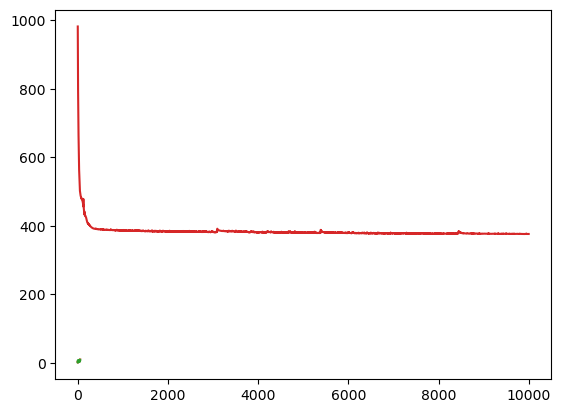

In [19]:
plt.plot(trial_losses)
plt.show()

In [20]:
np.min(trial_losses)

375.876220703125

In [21]:
all_losses

[-368.96527099609375,
 -375.5493469238281,
 -418.84417724609375,
 -365.76898193359375,
 -364.9815979003906,
 -404.5364074707031,
 -400.85400390625,
 -371.5802307128906,
 -368.50274658203125,
 -375.921875]

In [22]:
# Compute statistics across trials
mean_losses = np.mean(all_losses, axis=0)
std_losses = np.std(all_losses, axis=0)
mean_trial_time = np.mean(trial_times)
std_trial_time = np.std(trial_times)

In [23]:
# Output results
print("Training Results:")
print(f"Mean Loss (Final Epoch): {-mean_losses}, Std Loss: {std_losses}")
print(f"Mean Training Time: {mean_trial_time}s, Std Training Time: {std_trial_time}s")
print(f"Final mu values (across trials): {np.array(final_mu_values)}")

Training Results:
Mean Loss (Final Epoch): 381.5504638671875, Std Loss: 18.19646609297658
Mean Training Time: 2854.167358636856s, Std Training Time: 426.58330833060865s
Final mu values (across trials): [[1.3214964 1.931032  2.4867246 3.0986772 3.7716982]
 [1.325852  1.9382386 2.5067675 3.2452312 3.245308 ]
 [1.4864174 2.3139815 3.2526832 5.637706  6.699405 ]
 [1.3015685 1.8654491 2.3950615 2.928883  3.682761 ]
 [1.2863718 1.8482732 2.3735638 2.9185526 3.6811347]
 [1.4864028 2.3187706 3.2722533 3.933702  4.0677195]
 [1.4783236 2.30527   3.248696  6.6942797 6.6978755]
 [1.293493  1.8537216 2.383719  2.9358108 3.6908727]
 [1.2927252 1.8545793 2.3772132 2.908752  3.6582985]
 [1.3302063 1.9641626 2.4576383 2.548381  3.3832421]]


In [24]:
pred1[0][3].shape

IndexError: list index out of range

In [ ]:
# State filtering MSE
true_states = [t.numpy()[:, 0:1] for _, _, _, t in pred1]
true_states1 = [t.numpy()[:, 1:2] for _, _, _, t in pred1]

trial_mse_l1 = []
trial_mse_l2 = []

for trial in range(n_trials):
    mse_l1 = 0.0
    mse_l2 = 0.0
    total_states = 0

    l1 = all_l1[trial]
    l2 = all_l2[trial]

    for filtered_l1, filtered_l2, ts, ts1 in zip(l1, l2, true_states, true_states1):
        mse_l1 += (np.diag(filtered_l1.detach().numpy() == ts) ).sum()
        # print(filtered_l1.shape)
        # print(ts.shape)
        mse_l2 += (np.diag(filtered_l2.detach().numpy() ==  ts1)).sum()
        total_states += ts.shape[0]
    # print(mse_l1)
    # print(total_states)
    

    mse_l1 /= total_states
    mse_l2 /= total_states

    trial_mse_l1.append(mse_l1)
    trial_mse_l2.append(mse_l2)

# Calculate average error and standard deviation
average_mse_l1 = np.mean(trial_mse_l1)
std_mse_l1 = np.std(trial_mse_l1)

average_mse_l2 = np.mean(trial_mse_l2)
std_mse_l2 = np.std(trial_mse_l2)

# Print results
print("State Filtering MSE Results:")
print(f"Average MSE for l1: {average_mse_l1:.4f}, Std Dev: {std_mse_l1:.4f}")
print(f"Average MSE for l2: {average_mse_l2:.4f}, Std Dev: {std_mse_l2:.4f}")

# Print MSE for each trial
for trial, (mse_l1, mse_l2) in enumerate(zip(trial_mse_l1, trial_mse_l2), 1):
    print(f"Trial {trial}: MSE l1 = {mse_l1:.4f}, MSE l2 = {mse_l2:.4f}")


In [ ]:
trial_mse_l1

In [ ]:

trial_mse_l2


In [ ]:
# Calculate the total number of parameters
total_params = sum(p.numel() for p in net.parameters())

# Print the result
print(f"Total number of parameters: {total_params}")